In [1]:
import illustris_python as il
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
import tempfile
import h5py
import seaborn as sns
import itertools
from astropy.cosmology import Planck15 as cosmo
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline

In [2]:
def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    
    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string
    
    return r

In [3]:
sim_name = "TNG50-1"
basePath = 'sims.TNG/TNG50-1/output'
field=['SubhaloHalfmassRadType','SubhaloFlag','SubhaloSFR','SubhaloMassInRadType']
baseUrl = 'http://www.tng-project.org/api/TNG50-1/snapshots/'
headers={"api-key":"29fdb501f084ab3bde756d4827030bcb"}

In [4]:
snaps=get(baseUrl)
snaprs=[(snaps[i]['number'],np.round(snaps[i]['redshift'],3)) for i in range(len(snaps))]
snaprs[70:94]

[(70, 0.44),
 (71, 0.42),
 (72, 0.4),
 (73, 0.38),
 (74, 0.361),
 (75, 0.348),
 (76, 0.329),
 (77, 0.31),
 (78, 0.298),
 (79, 0.273),
 (80, 0.261),
 (81, 0.244),
 (82, 0.226),
 (83, 0.214),
 (84, 0.197),
 (85, 0.18),
 (86, 0.169),
 (87, 0.153),
 (88, 0.142),
 (89, 0.126),
 (90, 0.11),
 (91, 0.099),
 (92, 0.084),
 (93, 0.074)]

In [5]:
h=0.6774

def assign_fields(data,rs):
    ms=data['SubhaloMassInRadType'][:,4]*1e10/h
    r=data['SubhaloHalfmassRadType'][:,4]/h
    sfr=data['SubhaloSFR']
    z=rs*np.ones(len(ms))
    flags=data['SubhaloFlag']
    ids=np.array(list(range(len(ms))))
    
    good_ones=np.where((flags==True) &(ms > 0) & (sfr > 0))
    fields=[ms,r,sfr,z,flags,ids]
    newfields=[field[good_ones] for field in fields]
    ms,r,sfr,z,flags,ids=newfields
    
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)

    req_range=np.where((log_ms>8)&(log_ms<11.5))

    fields=[ms,r,sfr,z,flags,ids]
    newfields=[field[req_range] for field in fields]
    ms,r,sfr,z,flags,ids=newfields
    
    return ms,r,sfr,z,flags,ids

In [6]:
def speagle_params(z):
    t=cosmo.age(z).value
    return 0.84-0.026*t, -(6.51-0.11*t)

def speagle(z,logmass):
    return speagle_params(z)[0]*logmass+speagle_params(z)[1]

def whittaker(z,logmass):
    a=0.70-0.13*z
    b=0.38+1.14*z-0.19*z*z-10.5*a
    return a*logmass+b

def pearson(z,logmass):
    slope=1.1+0.5*np.log(0.03+z)
    intercept=0.38+0.12*z-10.5*slope
    return slope*logmass+intercept

def compare_mainseq(z,log_ms,log_sfr):
    fig=plt.figure(figsize=(4,3))
    ax=fig.add_subplot(111)
    ax.plot(log_ms,log_sfr,'.',markersize=2)
    x=np.linspace(8,11.5,len(log_ms))
    if z>=0.2:
        pearson_values=pearson(z,x)
        if z!=0.4:
            ax.plot(x,pearson_values,label='Pearson+18',linewidth=4,color='green')
        if z==0.4:
            ax.plot(x,pearson_values,label='Pearson+18',linewidth=4,color='brown')
    speagle_values=speagle(z,x)
    whit=whittaker(z,x)

    ax.plot(x,speagle_values,label='Speagle+14',linewidth=4,color='red')
    ax.plot(x,whit,label='Whitaker+12',linewidth=4,color='black')
    
    ax.set_xlim(8,11.5)
    ax.set_xlabel('log Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}$]')
    ax.set_ylabel('log Star Formation Rate [yr$^{-1}$]')
    ax.legend()
    plt.show()

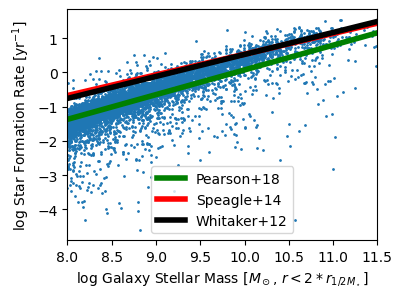

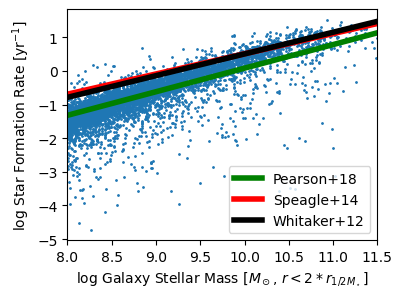

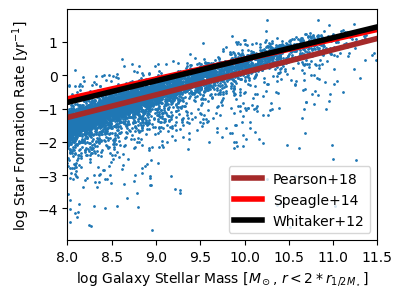

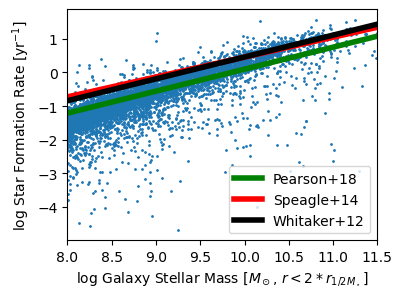

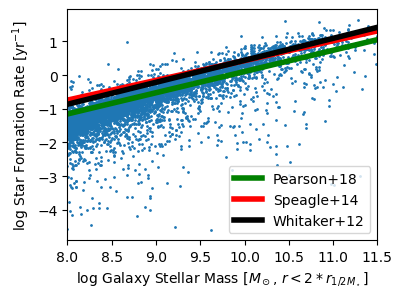

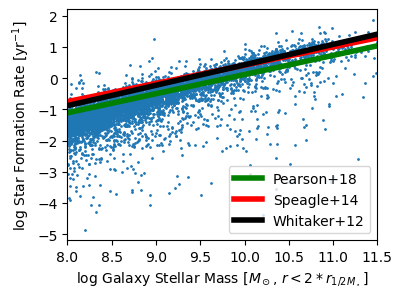

In [7]:
full_data=[]
for snap,rs in snaprs[70:76]:
    data=il.groupcat.loadSubhalos(basePath,snap,fields=field)
    ms,r,sfr,z,flags,ids=assign_fields(data,rs)
    full_data.append([ms,r,sfr,z,flags,ids])
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)
    compare_mainseq(rs,log_ms,log_sfr)

In [8]:
def bins(log_ms,log_sfr,nbins):
    mass_bins=np.linspace(log_ms.min(),log_ms.max(),nbins+1,endpoint=True)
    bin_indices=np.digitize(log_ms, mass_bins, right=False)
    binned_data={bin_start:[] for bin_start in mass_bins[0:-1]}

    for i, bin_start in enumerate(mass_bins[0:]):
        mask=bin_indices==i+1
        binned_data[bin_start]=list(zip(log_ms[mask],log_sfr[mask]))
        
    logms_to_plot=[(mass_bins[i]+mass_bins[i+1])/2 for i in range(len(mass_bins)-1)]
    logsfr_to_plot = [np.median([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]
    std_logsfr = [np.std([i[1] for i in binned_data[bin_start]]) for bin_start in mass_bins[0:-1]]
    
    return logms_to_plot,logsfr_to_plot,std_logsfr

In [9]:
def line(x,m,c):
    return m*x+c

def plot_pearson(z,log_ms,log_sfr,logms_binned,logsfr_binned,std):
    fig=plt.figure(figsize=(4,3))
    ax=fig.add_subplot(111)
    ax.plot(log_ms,log_sfr,'.',markersize=2)
    x=np.linspace(8,11.5,len(log_ms))
    pearson_values=pearson(z,x)
    popt,pcov=curve_fit(line,logms_binned,logsfr_binned)
    
    ax.plot(x,pearson_values,label='Pearson+2018',linewidth=4,color='brown')
    ax.plot(x,line(x,popt[0],popt[1]),label='Best Fit',linewidth=4,color='black')
    cs1=CubicSpline(x,pearson_values+0.3)
    cs2=CubicSpline(x,pearson_values-0.3)
    ax.fill_between(x,cs1(x),cs2(x),color='green',alpha=0.3)
    ax.errorbar(logms_binned,logsfr_binned,yerr=std,color='orange',zorder=5,fmt='o')

    ax.set_xlim(8,11.5)
    ax.set_xlabel('log Galaxy Stellar Mass [$M_\odot$, $r < R_{eff}$]')
    ax.set_ylabel('log Star Formation Rate [yr$^{-1}$]')
    ax.legend()
    plt.show()

In [10]:
def select_r(ms,r,sfr,z,flags,ids):
    good_ones=np.where(r > 0)
    fields=[ms,r,sfr,z,flags,ids]

    newfields=[field[good_ones] for field in fields]
    ms,r,sfr,z,flags,ids=newfields
    
    return ms,r,sfr,z,flags,ids

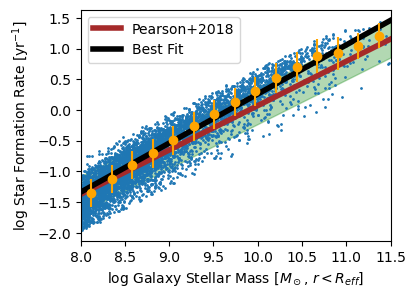

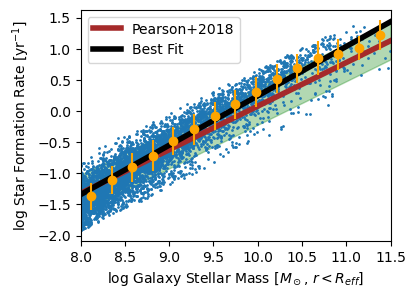

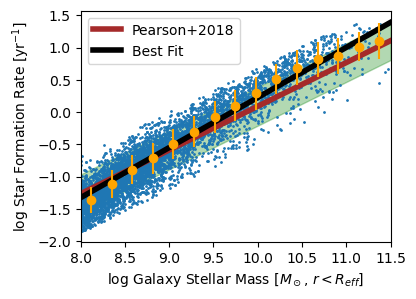

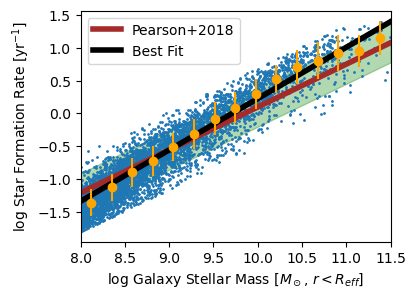

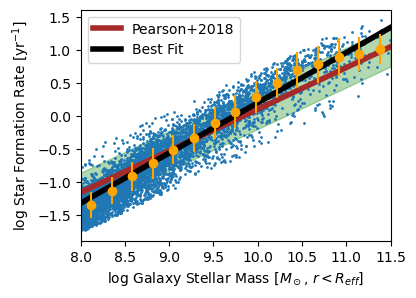

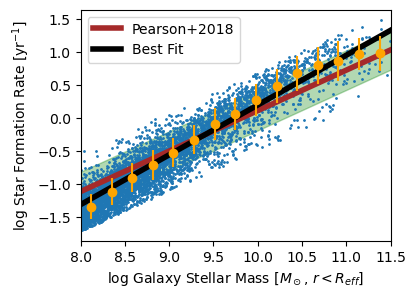

In [11]:
for i in range(len(full_data)):
    ms,r,sfr,z,flags,ids=full_data[i]
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)
    good_ones=np.where((abs(pearson(z[0],log_ms)-log_sfr)<0.6))
    fields=[ms,r,sfr,z,flags,ids]
    newfields=[field[good_ones] for field in fields]
    [ms,r,sfr,z,flags,ids]=newfields
    
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)    
    logms_binned,logsfr_binned,std=bins(log_ms,log_sfr,15)
    
    plot_pearson(z[0],log_ms,log_sfr,logms_binned,logsfr_binned,std)
    
    ms,r,sfr,z,flags,ids=select_r(ms,r,sfr,z,flags,ids)
    [ms,r,sfr,z,flags,ids]=newfields
    full_data[i]=newfields

In [12]:
all_ms=np.array([])
all_r=np.array([])
all_sfr=np.array([])
all_z=np.array([])
all_id=np.array([])

for data in full_data:
    ms,r,sfr,z,flags,ids=data
    all_ms=np.concatenate((all_ms,ms))
    all_r=np.concatenate((all_r,r))
    all_sfr=np.concatenate((all_sfr,sfr))
    all_z=np.concatenate((all_z,z))
    all_id=np.concatenate((all_id,ids))

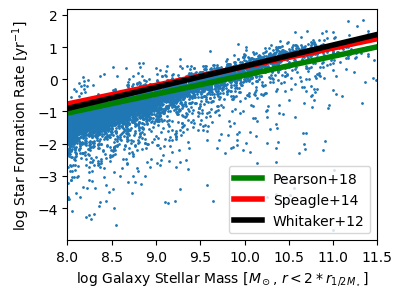

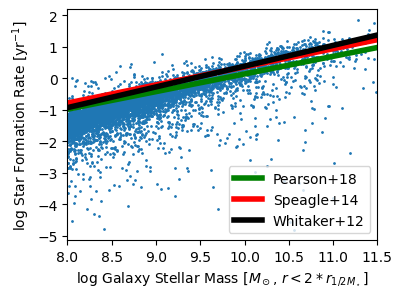

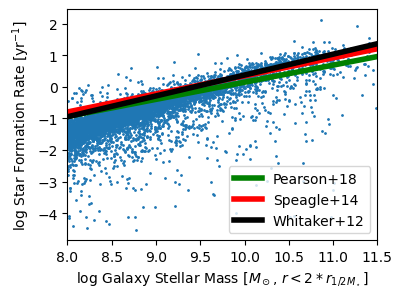

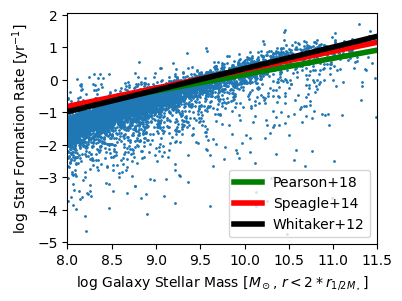

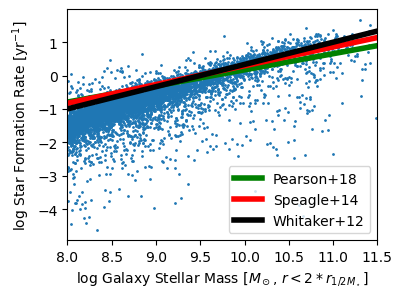

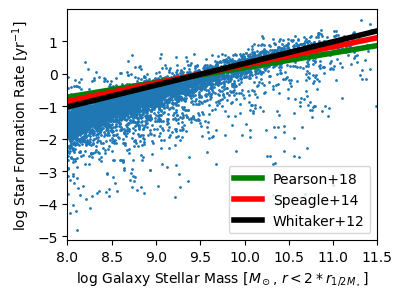

In [13]:
full_data=[]
for snap,rs in snaprs[76:82]:
    data=il.groupcat.loadSubhalos(basePath,snap,fields=field)
    ms,r,sfr,z,flags,ids=assign_fields(data,rs)
    full_data.append([ms,r,sfr,z,flags,ids])
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)
    compare_mainseq(rs,log_ms,log_sfr)

In [14]:
def plot_whit(z,log_ms,log_sfr,logms_binned,logsfr_binned,std):
    fig=plt.figure(figsize=(4,3))
    ax=fig.add_subplot(111)
    ax.plot(log_ms,log_sfr,'.',markersize=2)
    x=np.linspace(8,11.5,len(log_ms))
    whit_values=whittaker(z,x)
    popt,pcov=curve_fit(line,logms_binned,logsfr_binned)
    
    ax.plot(x,whit_values,label='Whitaker+12',linewidth=4,color='brown')
    ax.plot(x,line(x,popt[0],popt[1]),label='Best Fit to Median-Binned Data',linewidth=4,color='black')
    cs1=CubicSpline(x,whit_values+0.34)
    cs2=CubicSpline(x,whit_values-0.34)
    ax.fill_between(x,cs1(x),cs2(x),color='green',alpha=0.3)
    ax.errorbar(logms_binned,logsfr_binned,yerr=std,color='orange',zorder=5,fmt='o')

    ax.set_xlim(8,11.5)
    ax.set_xlabel('log Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}$]')
    ax.set_ylabel('log Star Formation Rate [yr$^{-1}$]')
    ax.legend()
    plt.show()

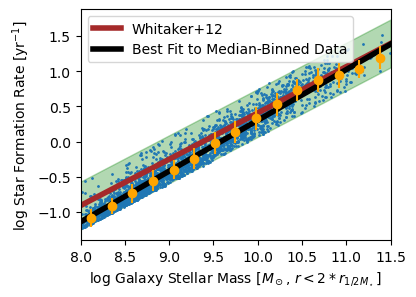

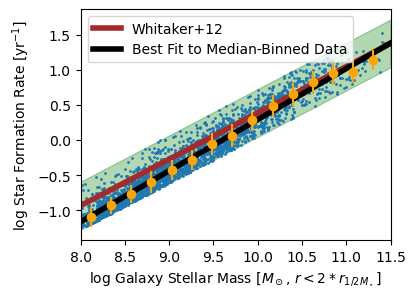

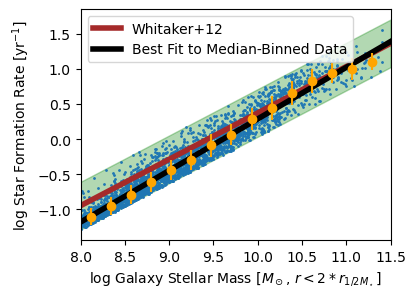

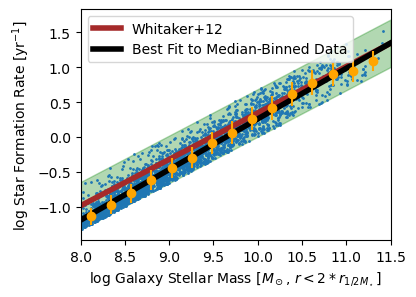

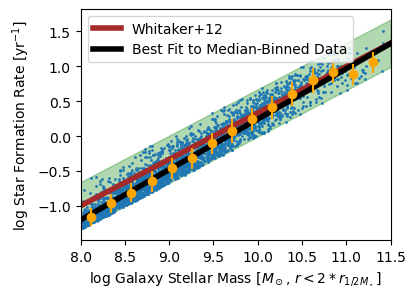

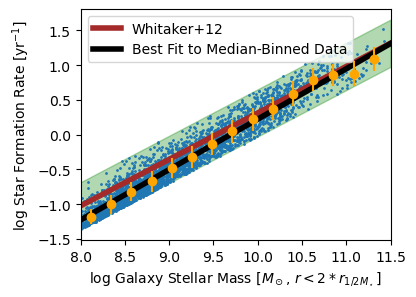

In [15]:
for i in range(len(full_data)):
    ms,r,sfr,z,flags,ids=full_data[i]
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)
    good_ones=np.where((abs(whittaker(z[0],log_ms)-log_sfr)<0.34))
    fields=[ms,r,sfr,z,flags,ids]
    newfields=[field[good_ones] for field in fields]
    [ms,r,sfr,z,flags,ids]=newfields
    
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)    
    logms_binned,logsfr_binned,std=bins(log_ms,log_sfr,15)
    
    plot_whit(z[0],log_ms,log_sfr,logms_binned,logsfr_binned,std)
    
    ms,r,sfr,z,flags,ids=select_r(ms,r,sfr,z,flags,ids)
    [ms,r,sfr,z,flags,ids]=newfields
    full_data[i]=newfields

In [16]:
for data in full_data:
    ms,r,sfr,z,flags,ids=data
    all_ms=np.concatenate((all_ms,ms))
    all_r=np.concatenate((all_r,r))
    all_sfr=np.concatenate((all_sfr,sfr))
    all_z=np.concatenate((all_z,z))
    all_id=np.concatenate((all_id,ids))

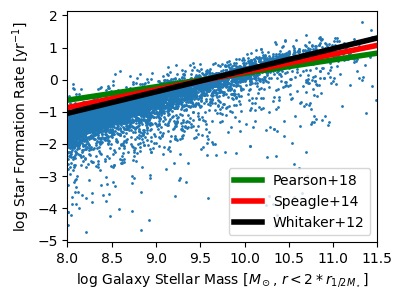

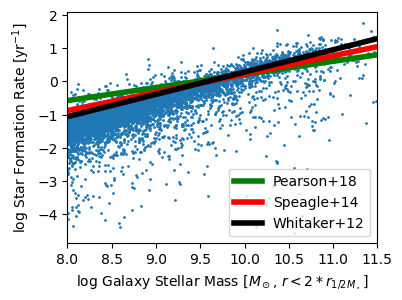

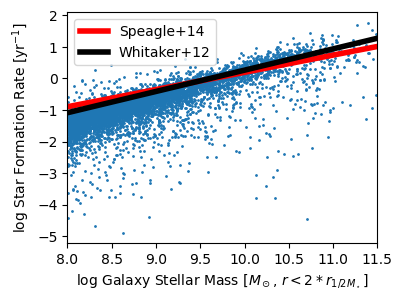

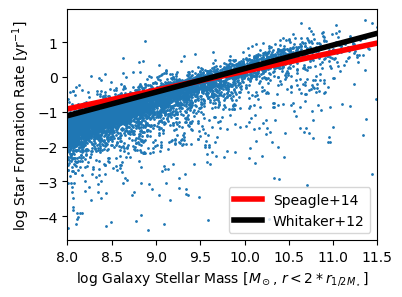

In [17]:
full_data=[]
for snap,rs in snaprs[82:86]:
    data=il.groupcat.loadSubhalos(basePath,snap,fields=field)
    ms,r,sfr,z,flags,ids=assign_fields(data,rs)
    full_data.append([ms,r,sfr,z,flags,ids])
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)
    compare_mainseq(rs,log_ms,log_sfr)

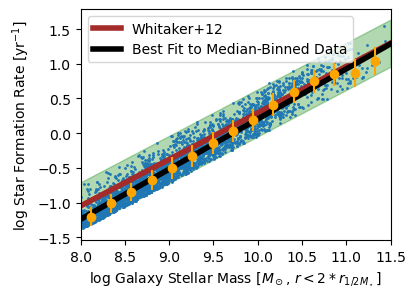

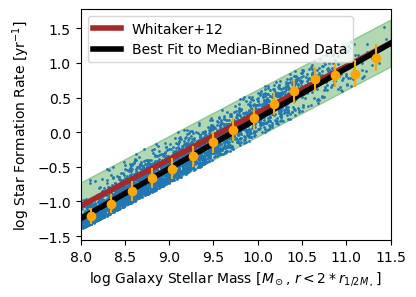

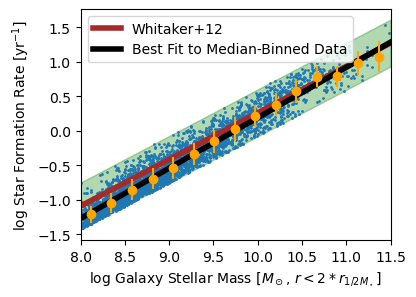

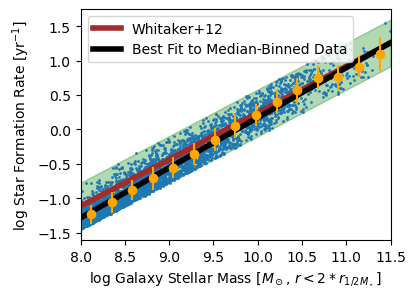

In [18]:
for i in range(len(full_data)):
    ms,r,sfr,z,flags,ids=full_data[i]
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)
    good_ones=np.where((abs(whittaker(z[0],log_ms)-log_sfr)<0.34))
    fields=[ms,r,sfr,z,flags,ids]
    newfields=[field[good_ones] for field in fields]
    [ms,r,sfr,z,flags,ids]=newfields
    
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)    
    logms_binned,logsfr_binned,std=bins(log_ms,log_sfr,15)
    
    plot_whit(z[0],log_ms,log_sfr,logms_binned,logsfr_binned,std)
    
    ms,r,sfr,z,flags,ids=select_r(ms,r,sfr,z,flags,ids)
    [ms,r,sfr,z,flags,ids]=newfields
    full_data[i]=newfields

In [19]:
for data in full_data:
    ms,r,sfr,z,flags,ids=data
    all_ms=np.concatenate((all_ms,ms))
    all_r=np.concatenate((all_r,r))
    all_sfr=np.concatenate((all_sfr,sfr))
    all_z=np.concatenate((all_z,z))
    all_id=np.concatenate((all_id,ids))

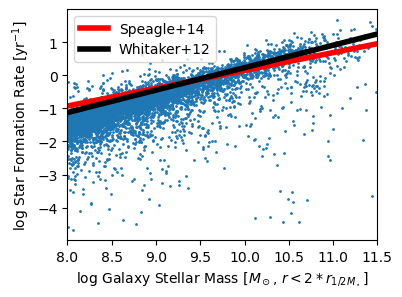

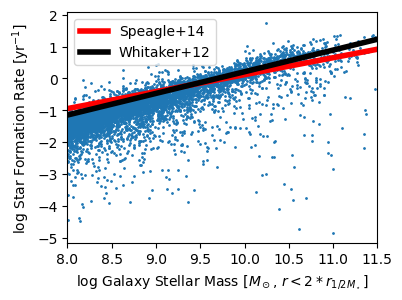

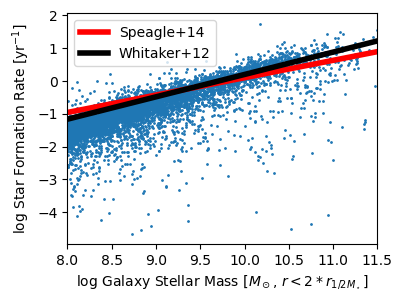

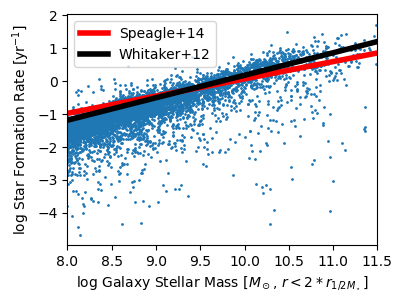

In [20]:
full_data=[]
for snap,rs in snaprs[86:90]:
    data=il.groupcat.loadSubhalos(basePath,snap,fields=field)
    ms,r,sfr,z,flags,ids=assign_fields(data,rs)
    full_data.append([ms,r,sfr,z,flags,ids])
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)
    compare_mainseq(rs,log_ms,log_sfr)

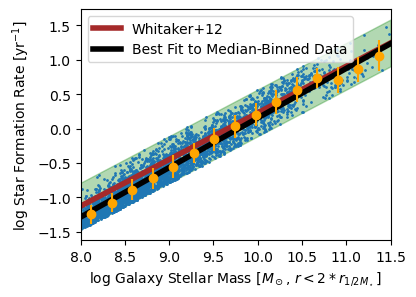

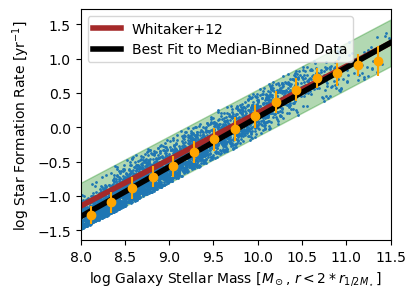

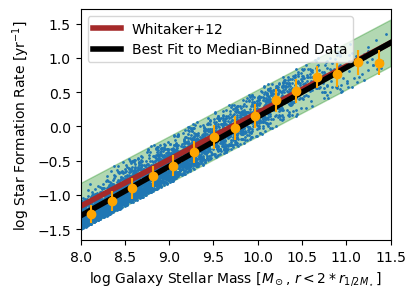

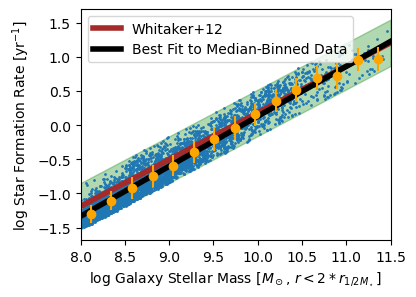

In [21]:
for i in range(len(full_data)):
    ms,r,sfr,z,flags,ids=full_data[i]
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)
    good_ones=np.where((abs(whittaker(z[0],log_ms)-log_sfr)<0.34))
    fields=[ms,r,sfr,z,flags,ids]
    newfields=[field[good_ones] for field in fields]
    [ms,r,sfr,z,flags,ids]=newfields
    
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)    
    logms_binned,logsfr_binned,std=bins(log_ms,log_sfr,15)
    
    plot_whit(z[0],log_ms,log_sfr,logms_binned,logsfr_binned,std)
    
    ms,r,sfr,z,flags,ids=select_r(ms,r,sfr,z,flags,ids)
    [ms,r,sfr,z,flags,ids]=newfields
    full_data[i]=newfields

In [22]:
for data in full_data:
    ms,r,sfr,z,flags,ids=data
    all_ms=np.concatenate((all_ms,ms))
    all_r=np.concatenate((all_r,r))
    all_sfr=np.concatenate((all_sfr,sfr))
    all_z=np.concatenate((all_z,z))
    all_id=np.concatenate((all_id,ids))

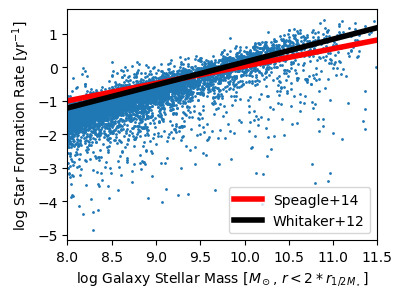

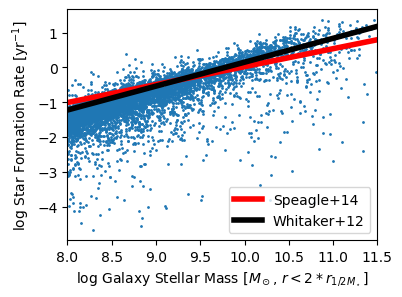

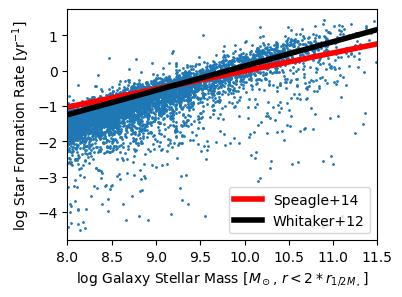

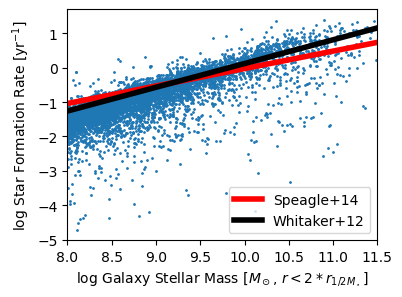

In [23]:
full_data=[]
for snap,rs in snaprs[90:94]:
    data=il.groupcat.loadSubhalos(basePath,snap,fields=field)
    ms,r,sfr,z,flags,ids=assign_fields(data,rs)
    full_data.append([ms,r,sfr,z,flags,ids])
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)
    compare_mainseq(rs,log_ms,log_sfr)

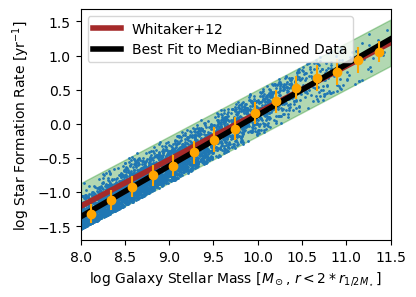

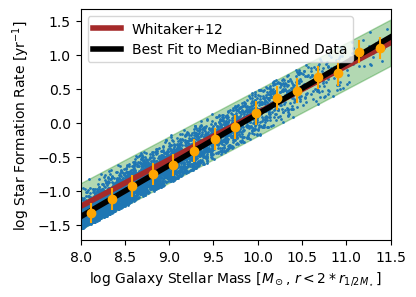

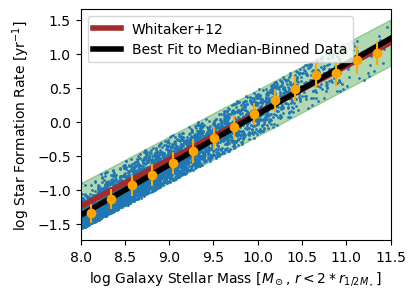

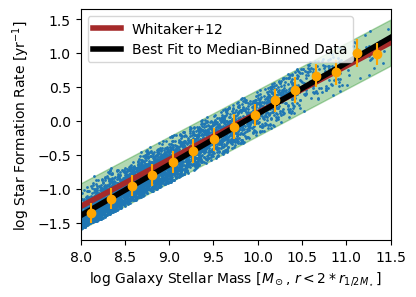

In [24]:
for i in range(len(full_data)):
    ms,r,sfr,z,flags,ids=full_data[i]
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)
    good_ones=np.where((abs(whittaker(z[0],log_ms)-log_sfr)<0.34))
    fields=[ms,r,sfr,z,flags,ids]
    newfields=[field[good_ones] for field in fields]
    [ms,r,sfr,z,flags,ids]=newfields
    
    log_ms=np.log10(ms)
    log_sfr=np.log10(sfr)    
    logms_binned,logsfr_binned,std=bins(log_ms,log_sfr,15)
    
    plot_whit(z[0],log_ms,log_sfr,logms_binned,logsfr_binned,std)
    
    ms,r,sfr,z,flags,ids=select_r(ms,r,sfr,z,flags,ids)
    [ms,r,sfr,z,flags,ids]=newfields
    full_data[i]=newfields

In [25]:
for data in full_data:
    ms,r,sfr,z,flags,ids=data
    all_ms=np.concatenate((all_ms,ms))
    all_r=np.concatenate((all_r,r))
    all_sfr=np.concatenate((all_sfr,sfr))
    all_z=np.concatenate((all_z,z))
    all_id=np.concatenate((all_id,ids))

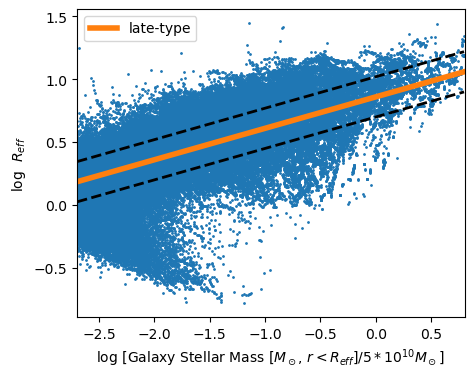

In [26]:
log_ms=np.log10(all_ms)
log_r=np.log10(all_r)
log_ms_scaled=log_ms-np.log10(5e+10)

fig=plt.figure(figsize=(5,4))
ax=fig.add_subplot(111)

ax.plot(log_ms_scaled,log_r,'.',markersize=2)

ax.set_xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < R_{eff}]/5*10^{10}M_\odot$]')
ax.set_ylabel('log  $R_{eff}$')

x=np.linspace(min(log_ms_scaled),max(log_ms_scaled))
ax.plot(x,0.86+0.25*x,label='late-type',linewidth=4)
ax.plot(x,0.86+0.25*x-0.16,'--',color='black',linewidth=2)
ax.plot(x,0.86+0.25*x+0.16,'--',color='black',linewidth=2)
ax.set_xlim(-2.7,0.802)


ax.legend()
plt.show()

In [27]:
def mass_size(logmass_scaled):
    return 0.86+0.25*logmass_scaled

good_ones=np.where(abs(mass_size(log_ms_scaled)-log_r)<0.32)
fields=[all_ms,all_r,all_sfr,all_z,all_id]

newfields=[field[good_ones] for field in fields]
all_ms,all_r,all_sfr,all_z,all_id=newfields

In [28]:
log_ms=np.log10(all_ms)
log_r=np.log10(all_r)
log_ms_scaled=log_ms-np.log10(5e+10)

In [29]:
logms_scaled_binned,logreff_binned,std=bins(log_ms_scaled,log_r,10)

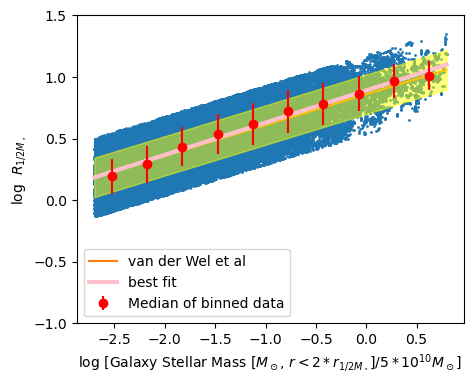

In [30]:
x_values=np.linspace(log_ms_scaled.min(),log_ms_scaled.max(),100)
m,c=curve_fit(line,logms_scaled_binned,logreff_binned)[0]

fig=plt.figure(figsize=(5,4))
ax=fig.add_subplot(111)
ax.plot(log_ms_scaled,log_r,'.',markersize=2)
ax.plot(x_values,mass_size(x_values),label='van der Wel et al')
ax.plot(x_values,x_values*m+c,label='best fit',zorder=3,color='pink',linewidth=3)
ax.errorbar(logms_scaled_binned,logreff_binned,yerr=std,color='red',zorder=3,label='Median of binned data',fmt='o')
ax.fill_between(x_values,mass_size(x_values)+0.16,mass_size(x_values)-0.16,color='yellow',alpha=0.5,zorder=2)

ax.set_xlabel('log [Galaxy Stellar Mass [$M_\odot$, $r < 2*r_{1/2 M_\star}]/5*10^{10}M_\odot$]')
ax.set_ylabel('log  $R_{1/2 M_\star}$')
ax.set_ylim(-1,1.5)

ax.legend()
plt.show()

In [31]:
df=pd.DataFrame({'SubhaloID':all_id,'$z$':all_z})
df

,SubhaloID,$z$
0,2.0,0.440
1,3.0,0.440
2,9.0,0.440
3,13.0,0.440
4,22.0,0.440
...,...,...
75880,812765.0,0.074
75881,814699.0,0.074
75882,817529.0,0.074
75883,821944.0,0.074


In [32]:
df.to_csv('IDs0.05-0.45.csv')

In [33]:
def dump_to_csv(snapr):
    rs = np.round(snapr[1], 3)
    sub_ids = df[df['$z$'] == rs]['SubhaloID'].to_numpy().astype(int)
    a = 1 / (1 + rs)

    full_data = il.groupcat.loadSubhalos(basePath, snapr[0], fields=['SubhaloMassType', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloMass', 'SubhaloSFR', 'SubhaloVmax', 'SubhaloVelDisp'])
    print('Data Loaded')

    mg = full_data['SubhaloMassType'][sub_ids][:, 0] * 1e10 / h
    ms = full_data['SubhaloMassType'][sub_ids][:, 4] * 1e10 / h
    mdm = full_data['SubhaloMassType'][sub_ids][:, 1] * 1e10 / h
    shmr = full_data['SubhaloHalfmassRadType'][sub_ids][:, 4] * a / h
    thmr = full_data['SubhaloHalfmassRad'][sub_ids] * a / h
    sfr = full_data['SubhaloSFR'][sub_ids]
    v = full_data['SubhaloVmax'][sub_ids]
    s = full_data['SubhaloVelDisp'][sub_ids]
    tm = full_data['SubhaloMass'][sub_ids] * 1e10 / h
    rs = np.full((len(mg)), rs)

    df2 = pd.DataFrame({'SubhaloID': sub_ids, '$M_{gas},M_{\odot}$': mg, '$M_{stellar},M_{\odot}$': ms, '$M_{DM},M_{\odot}$': mdm, '$R_{1/2M_{sub}}$(kpc)': thmr, 'SFR($M_{\odot}/yr$)': sfr, '$V_{max}$(km/s)': v, '$\sigma_v$(km/s)': s,
                        'M': tm, 'z': rs, '$R_{1/2M_*}$': shmr})

    csv_file_path = 'SUBHALOS_0.05-0.45.csv'

    if not os.path.isfile(csv_file_path):
        df2.to_csv(csv_file_path, mode='w', index=False, header=True)
    else:
        df2.to_csv(csv_file_path, mode='a', index=False, header=False)

    print('Successful')

In [34]:
for snapr in snaprs[70:94][::-1]:
    dump_to_csv(snapr)

Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
Data Loaded
Successful
